<a href="https://colab.research.google.com/github/SamarthGarg09/ImageSegmentationUsingUnet/blob/main/UnetForImageSegementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Image Segmentation Using Unet**

##Import

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

#Dataset-Oxford-iit dataset
##Contains pet-images,their segementation masks 

In [2]:
dataset,info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete8REX0C/oxford_iiit_pet-train.tfrecord


  0%|          | 0/3680 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete8REX0C/oxford_iiit_pet-test.tfrecord


  0%|          | 0/3669 [00:00<?, ? examples/s]

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


Lets briefly examine the dataset

In [3]:
print(dataset.keys())
print(info)

dict_keys(['test', 'train'])
tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    version=3.2.0,
    description='The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
images for each class. The images have large variations in scale, pose and
lighting. All images have an associated ground truth annotation of breed.',
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
        'species': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=7349,
    splits={
        'test': 3669,
        'train': 3680,
    },
    supervised_keys=('image', 'label'),
    citation="""@InProceedings{parkhi12a,
      author       = "Parkhi, O. M. and Vedaldi

##Preprocess the dataset
* Data augmentation-horizontal flipping
* Resizing
* Normalizing the pixel value

In [4]:
def random_flip(input_image, input_mask):
    if tf.random.uniform(())>0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
    return input_image,input_mask

def normalize(input_image, input_mask):
    input_image = tf.cast(input_image,dtype = tf.float32)
    input_image /= 255.0
    input_mask -= 1
    return input_image, input_mask

# to run function in graph mode
@tf.function
def load_image_train(train_dataset):
    input_image = tf.image.resize(train_dataset['image'],(128,128),method = 'nearest')
    input_mask = tf.image.resize(train_dataset['segmentation_mask'],(128,128),method = 'nearest')
    input_image, input_mask = random_flip(input_image, input_mask)
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

@tf.function
def load_image_test(test_dataset):
    input_image = tf.image.resize(test_dataset['image'],(128,128),method = 'nearest')
    input_mask = tf.image.resize(test_dataset['segmentation_mask'],(128,128),method = 'nearest')
    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

As dataset already consists of the splitted data, we will call above methods to preprocess the data.



In [5]:
train_dataset = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = dataset['test'].map(load_image_test)

Tensor("sub:0", shape=(128, 128, 1), dtype=uint8)


In [6]:
# prepare batches for training and testing

BATCH_SIZE = 64
BUFFER_SIZE = 1000

train_dataset = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat().prefetch(-1)
test_dataset = test_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

##Vizualization Utilities 
#### which will help in visualizing data and metrics

In [7]:
class_names = ['pet','background','outline']

def display_iou_and_dice_score(display_list, iou, dice_score):
    metrics_list = [(idx, iou, dice_score) for idx, (iou, dice_score) in enumerate(zip(iou, dice_score)) if iou > 0.0]
    metrics_list.sort(key=lambda t:t[1], reverse = True)
    display_string_list = [f'{class_names[idx]} IOU:{iou} Dice Score:{dice_score}' for (idx, iou, dice_score) in metrics_list]
    display_string = '\n\n'.join(display_string_list)
    display(display_list,  ["Image", "Predicted Mask", "True Mask"],display_string)

def display(display_list, titles=[], display_string=None):
    plt.figure(figsize=(15,15))

    for i in range(len(display_list)):
        plt.subplot(1,len(display_list),i+1)
        plt.title(titles[i])
        plt.xticks([])
        plt.yticks([])
        if display_string and i == 1:
            plt.xlabel(display_string)
        img_array = tf.keras.preprocessing.image.array_to_img(display_list[i])
        plt.imshow(img_array)
    
    plt.show()

def show_image_from_dataset(dataset):
    for image, mask in dataset.take(1):
        sample_image, sample_mask = image, mask
    display([sample_image[0],sample_mask[0]], titles = ['Image','Mask'])


def plot_metrics(metric_name, title, ylim=5):
  '''plots a given metric from the model history'''
  plt.title(title)
  plt.ylim(0,ylim)
  plt.plot(model_history.history[metric_name],color='blue',label=metric_name)
  plt.plot(model_history.history['val_' + metric_name],color='green',label='val_' + metric_name)


<PIL.Image.Image image mode=RGB size=128x128 at 0x7FE16859BC50>
<PIL.Image.Image image mode=L size=128x128 at 0x7FE1687192D0>


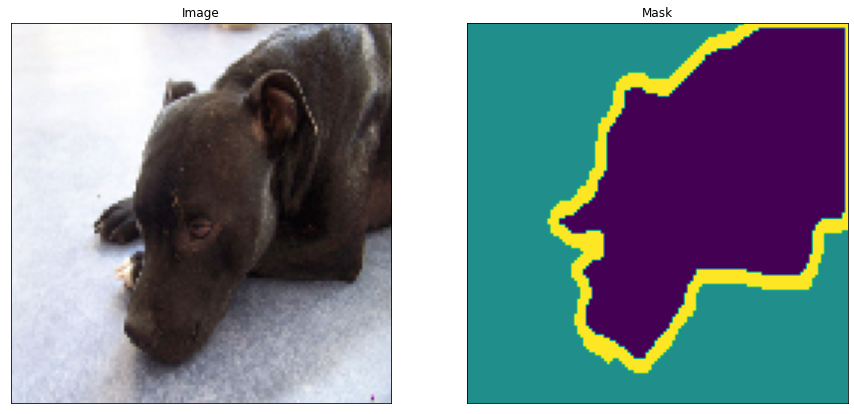

<PIL.Image.Image image mode=RGB size=128x128 at 0x7FE168647190>
<PIL.Image.Image image mode=L size=128x128 at 0x7FE1689D1810>


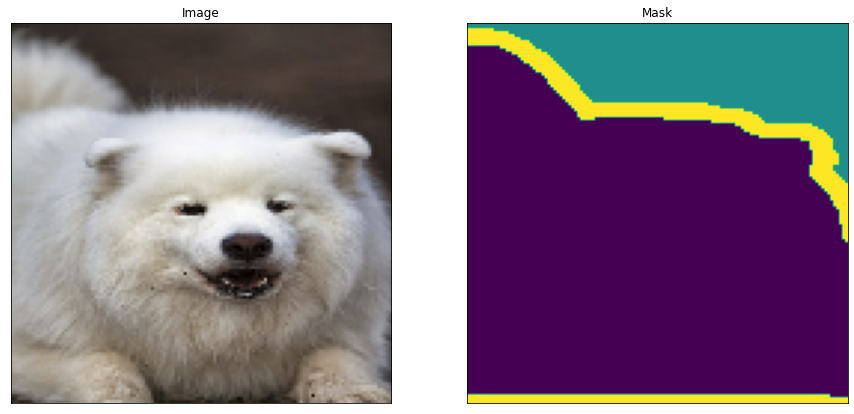

In [8]:
show_image_from_dataset(train_dataset)
show_image_from_dataset(test_dataset)

#Define Model
##U net

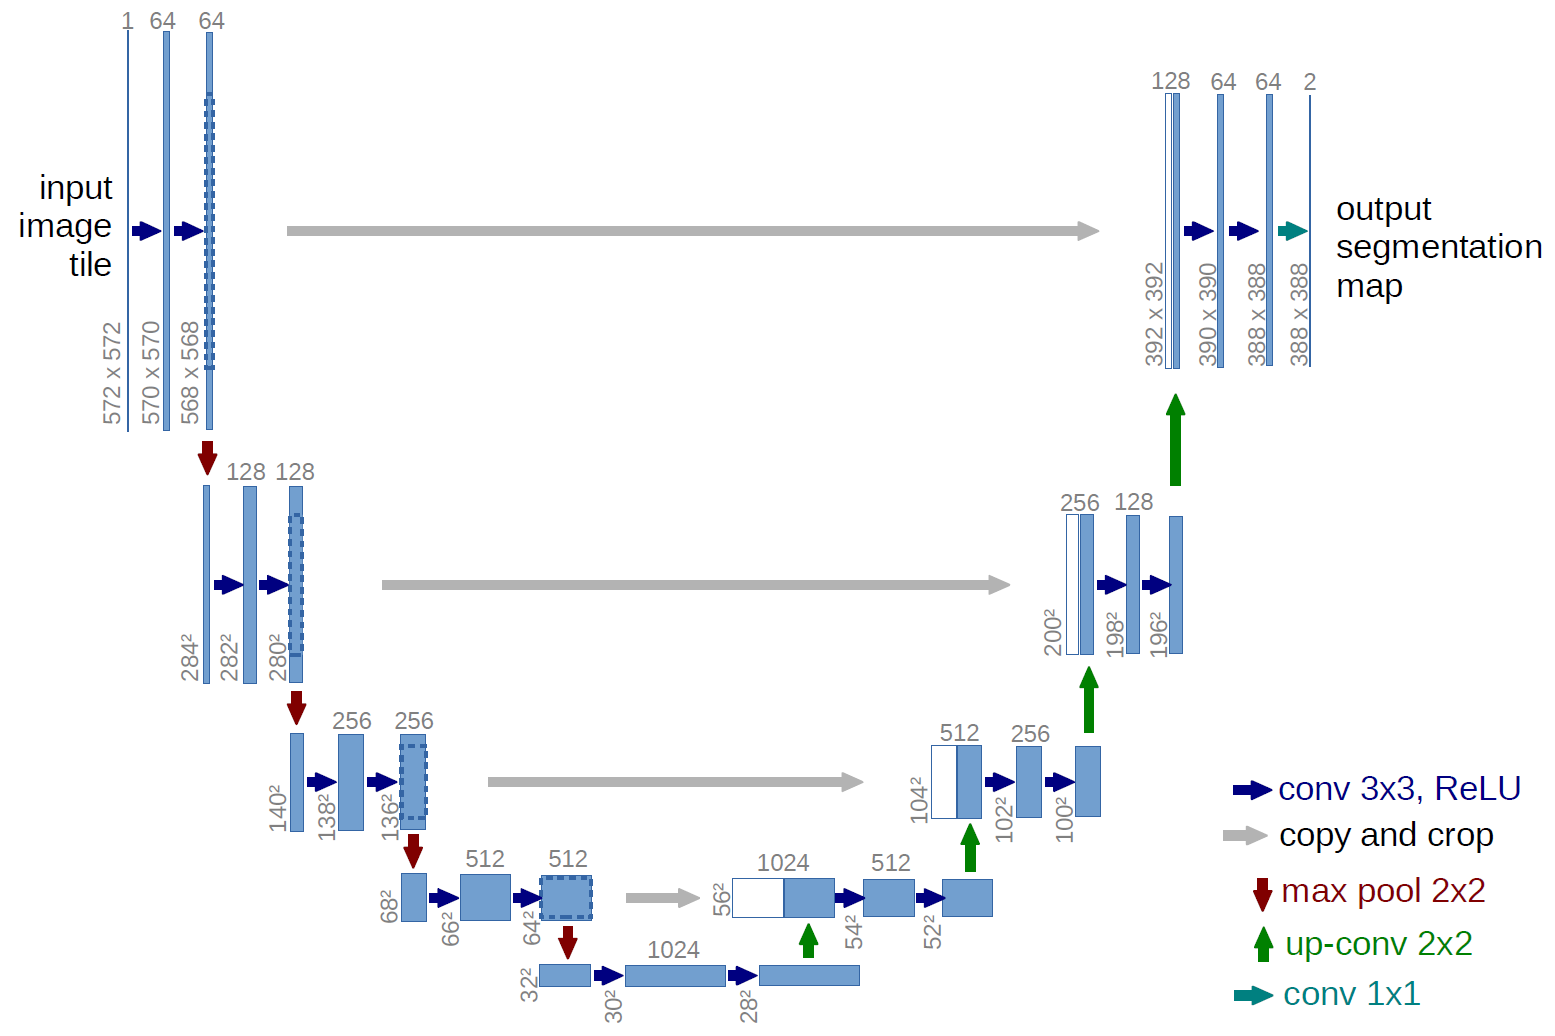

---
###Encoder part


In [9]:
def conv2d_block(inputs, n_filters, kernel_size = (3,3)):
    x = inputs
    for _ in range(2):
        x = tf.keras.layers.Conv2D(n_filters,kernel_size, kernel_initializer = 'he_uniform', padding = 'same' )(x)
        x = tf.keras.layers.Activation('relu')(x)
    return x

def encoder_block(inputs, n_filters, pool_size=(2,2), dropout = 0.5):
    f = conv2d_block(inputs, n_filters)
    x = tf.keras.layers.MaxPool2D(pool_size)(f)
    x = tf.keras.layers.Dropout(dropout) (x)
    return f, x

def encoder(inputs):
    f1,x = encoder_block(inputs, n_filters=64)
    f2,x = encoder_block(x, n_filters=128)
    f3,x = encoder_block(x, n_filters=256)
    f4,x = encoder_block(x, n_filters=512)
    # print(f4.shape)
    return (f1,f2,f3,f4),x 

Bottleneck-layer

In [10]:
def bottleneck(inputs):
    x = conv2d_block(inputs, 1024)
    return x



---
##Decoder


* We will also use transpose convolution to upscale the image.
* Use of skip connection to regain the information about spatial features.
* And then concatenatng output of transpose convolution with the respective skip connection along channel 3.
* In the final layer of decoder we used $(1*1)$ convolution to adjust the depth of the predicted label map to the no. of classes (i.e 3).

In [11]:
def decoder_block(inputs, conv_output, n_filters=64, kernel_size = (3,3), strides = (3,3), pool_size=(2,2), dropout = 0.5):
    x = tf.keras.layers.Conv2DTranspose(n_filters, kernel_size,
                                        strides=strides, padding = 'same')(inputs)
    x = tf.keras.layers.concatenate([x,conv_output])
    x = tf.keras.layers.Dropout(dropout)(x)
    x = conv2d_block(x, n_filters)


    return x

def decoder(inputs, conv_outputs, output_channels):
    x = bottleneck(inputs)
    f1, f2, f3, f4 = conv_outputs
    x = decoder_block(x, f4, 512,strides = (2,2))
    x = decoder_block(x, f3, 256,strides = (2,2))
    x = decoder_block(x, f2, 128,strides = (2,2))
    x = decoder_block(x, f1, 64,strides = (2,2))
    x = tf.keras.layers.Conv2D(output_channels, (1,1), activation = 'softmax')(x)
    return x

    

## Finally Combining altogether

In [12]:
# output channels will be equal to no. of classes
OUTPUT_CHANNEL = 3
def Unet():
    inputs = tf.keras.layers.Input(shape = (128,128,3,))
    (f1,f2,f3,f4), x = encoder(inputs)
    x = bottleneck(x)
    outputs = decoder(x,(f1,f2,f3,f4),output_channels = OUTPUT_CHANNEL)
    model = tf.keras.Model(inputs=inputs,outputs=outputs)
    return model

model = Unet()
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 activation (Activation)        (None, 128, 128, 64  0           ['conv2d[0][0]']                 
                                )                                                             

In [13]:
model.compile(
    optimizer='Adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics = ['accuracy']
)

#Train the model

In [14]:
TRAIN_LENGTH = info.splits['train'].num_examples
EPOCHS = 10
STEPS_PER_EPOCH = TRAIN_LENGTH//BATCH_SIZE
VALIDATION_STEPS = (info.splits['test'].num_examples)//BATCH_SIZE
checkpoint_path = "training_1/cp.ckpt"
callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_freq=5*(BATCH_SIZE),
                                                 verbose=1)
model_history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks = [callback],
    validation_data = test_dataset,
    validation_steps = VALIDATION_STEPS
)

Epoch 1/10
 1/57 [..............................] - ETA: 45:49 - loss: 1.4267 - accuracy: 0.5059INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


 3/57 [>.............................] - ETA: 6:37 - loss: 1.2809 - accuracy: 0.4516 INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


 5/57 [=>............................] - ETA: 6:22 - loss: 1.1673 - accuracy: 0.5046INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


 7/57 [==>...........................] - ETA: 6:06 - loss: 1.1055 - accuracy: 0.5310INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


 9/57 [===>..........................] - ETA: 5:53 - loss: 1.0792 - accuracy: 0.5380INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


11/57 [====>.........................] - ETA: 5:37 - loss: 1.0563 - accuracy: 0.5460INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


13/57 [=====>........................] - ETA: 5:27 - loss: 1.0375 - accuracy: 0.5563INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


15/57 [======>.......................] - ETA: 5:29 - loss: 1.0244 - accuracy: 0.5617INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


17/57 [=======>......................] - ETA: 5:11 - loss: 1.0144 - accuracy: 0.5671INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


19/57 [=========>....................] - ETA: 4:54 - loss: 1.0083 - accuracy: 0.5655INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


21/57 [==========>...................] - ETA: 4:41 - loss: 1.0009 - accuracy: 0.5691INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


23/57 [===========>..................] - ETA: 4:24 - loss: 0.9949 - accuracy: 0.5675INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


25/57 [============>.................] - ETA: 4:07 - loss: 0.9868 - accuracy: 0.5698INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


27/57 [=============>................] - ETA: 3:50 - loss: 0.9805 - accuracy: 0.5724INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


29/57 [==============>...............] - ETA: 3:34 - loss: 0.9751 - accuracy: 0.5729INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


31/57 [===============>..............] - ETA: 3:18 - loss: 0.9702 - accuracy: 0.5743INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


33/57 [================>.............] - ETA: 3:03 - loss: 0.9641 - accuracy: 0.5761INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


35/57 [=================>............] - ETA: 2:47 - loss: 0.9597 - accuracy: 0.5761INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


37/57 [==================>...........] - ETA: 2:32 - loss: 0.9534 - accuracy: 0.5781INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


39/57 [===================>..........] - ETA: 2:16 - loss: 0.9479 - accuracy: 0.5789INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


41/57 [====================>.........] - ETA: 2:01 - loss: 0.9430 - accuracy: 0.5798INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


43/57 [=====================>........] - ETA: 1:45 - loss: 0.9395 - accuracy: 0.5790INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


45/57 [======================>.......] - ETA: 1:30 - loss: 0.9353 - accuracy: 0.5797INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


47/57 [=======================>......] - ETA: 1:15 - loss: 0.9305 - accuracy: 0.5800INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


49/57 [========================>.....] - ETA: 1:00 - loss: 0.9264 - accuracy: 0.5800INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


51/57 [=========================>....] - ETA: 45s - loss: 0.9220 - accuracy: 0.5808INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


53/57 [==========================>...] - ETA: 30s - loss: 0.9181 - accuracy: 0.5807INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


55/57 [===========================>..] - ETA: 15s - loss: 0.9136 - accuracy: 0.5817INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


57/57 [==============================] - 523s 8s/step - loss: 0.9098 - accuracy: 0.5828 - val_loss: 0.7913 - val_accuracy: 0.6397
Epoch 2/10
INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


 2/57 [>.............................] - ETA: 2:06 - loss: 0.7741 - accuracy: 0.6525 INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


57/57 [==============================] - 220s 3s/step - loss: 0.8406 - accuracy: 0.5991 - val_loss: 0.7981 - val_accuracy: 0.6184
Epoch 3/10
53/57 [==========================>...] - ETA: 9s - loss: 0.7688 - accuracy: 0.6506 INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


55/57 [===========================>..] - ETA: 4s - loss: 0.7675 - accuracy: 0.6514INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


57/57 [==============================] - 202s 4s/step - loss: 0.7662 - accuracy: 0.6524 - val_loss: 0.7115 - val_accuracy: 0.6948
Epoch 4/10
INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


 4/57 [=>............................] - ETA: 1:43 - loss: 0.7221 - accuracy: 0.6841INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


 6/57 [==>...........................] - ETA: 3:22 - loss: 0.7209 - accuracy: 0.6877INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


 8/57 [===>..........................] - ETA: 4:02 - loss: 0.7139 - accuracy: 0.6928INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


10/57 [====>.........................] - ETA: 4:16 - loss: 0.7048 - accuracy: 0.6989INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


20/57 [=========>....................] - ETA: 2:39 - loss: 0.6992 - accuracy: 0.7056INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


22/57 [==========>...................] - ETA: 2:40 - loss: 0.6956 - accuracy: 0.7081INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


24/57 [===========>..................] - ETA: 2:39 - loss: 0.6958 - accuracy: 0.7085INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


26/57 [============>.................] - ETA: 2:35 - loss: 0.6923 - accuracy: 0.7105INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


28/57 [=============>................] - ETA: 2:30 - loss: 0.6881 - accuracy: 0.7133INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


34/57 [================>.............] - ETA: 1:53 - loss: 0.6839 - accuracy: 0.7166INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


36/57 [=================>............] - ETA: 1:46 - loss: 0.6833 - accuracy: 0.7171INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


38/57 [===================>..........] - ETA: 1:38 - loss: 0.6824 - accuracy: 0.7178INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


40/57 [====================>.........] - ETA: 1:30 - loss: 0.6811 - accuracy: 0.7186INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


42/57 [=====================>........] - ETA: 1:20 - loss: 0.6789 - accuracy: 0.7199INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


44/57 [======================>.......] - ETA: 1:11 - loss: 0.6778 - accuracy: 0.7208INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


46/57 [=======================>......] - ETA: 1:01 - loss: 0.6761 - accuracy: 0.7216INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


48/57 [========================>.....] - ETA: 50s - loss: 0.6739 - accuracy: 0.7229INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


50/57 [=========================>....] - ETA: 40s - loss: 0.6718 - accuracy: 0.7240INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


52/57 [==========================>...] - ETA: 28s - loss: 0.6699 - accuracy: 0.7249INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


54/57 [===========================>..] - ETA: 17s - loss: 0.6677 - accuracy: 0.7261INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


56/57 [============================>.] - ETA: 5s - loss: 0.6661 - accuracy: 0.7270 INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


57/57 [==============================] - 400s 7s/step - loss: 0.6654 - accuracy: 0.7270 - val_loss: 0.7191 - val_accuracy: 0.6989
Epoch 5/10
 1/57 [..............................] - ETA: 2:08 - loss: 0.7189 - accuracy: 0.6938INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


11/57 [====>.........................] - ETA: 2:26 - loss: 0.6615 - accuracy: 0.7284INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


13/57 [=====>........................] - ETA: 2:50 - loss: 0.6533 - accuracy: 0.7322INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


29/57 [==============>...............] - ETA: 1:34 - loss: 0.6531 - accuracy: 0.7366INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


31/57 [===============>..............] - ETA: 1:35 - loss: 0.6497 - accuracy: 0.7383INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


33/57 [================>.............] - ETA: 1:33 - loss: 0.6490 - accuracy: 0.7386INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


35/57 [=================>............] - ETA: 1:30 - loss: 0.6464 - accuracy: 0.7398INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


37/57 [==================>...........] - ETA: 1:26 - loss: 0.6435 - accuracy: 0.7412INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


39/57 [===================>..........] - ETA: 1:21 - loss: 0.6417 - accuracy: 0.7419INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


41/57 [====================>.........] - ETA: 1:14 - loss: 0.6405 - accuracy: 0.7422INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


43/57 [=====================>........] - ETA: 1:08 - loss: 0.6394 - accuracy: 0.7425INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


45/57 [======================>.......] - ETA: 1:02 - loss: 0.6391 - accuracy: 0.7427INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


47/57 [=======================>......] - ETA: 52s - loss: 0.6371 - accuracy: 0.7436INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


49/57 [========================>.....] - ETA: 43s - loss: 0.6357 - accuracy: 0.7441INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


51/57 [=========================>....] - ETA: 32s - loss: 0.6338 - accuracy: 0.7451INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


53/57 [==========================>...] - ETA: 22s - loss: 0.6327 - accuracy: 0.7455INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


57/57 [==============================] - 362s 6s/step - loss: 0.6316 - accuracy: 0.7461 - val_loss: 0.6436 - val_accuracy: 0.7343
Epoch 6/10
INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


 2/57 [>.............................] - ETA: 2:06 - loss: 0.5939 - accuracy: 0.7570 INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


 6/57 [==>...........................] - ETA: 3:27 - loss: 0.6004 - accuracy: 0.7534INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


10/57 [====>.........................] - ETA: 3:26 - loss: 0.5992 - accuracy: 0.7543INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


20/57 [=========>....................] - ETA: 2:21 - loss: 0.5964 - accuracy: 0.7590INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


22/57 [==========>...................] - ETA: 2:26 - loss: 0.5940 - accuracy: 0.7600INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


24/57 [===========>..................] - ETA: 2:26 - loss: 0.5932 - accuracy: 0.7609INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


26/57 [============>.................] - ETA: 2:25 - loss: 0.5909 - accuracy: 0.7620INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


28/57 [=============>................] - ETA: 2:21 - loss: 0.5882 - accuracy: 0.7633INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


32/57 [===============>..............] - ETA: 2:01 - loss: 0.5878 - accuracy: 0.7638INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


42/57 [=====================>........] - ETA: 1:07 - loss: 0.5875 - accuracy: 0.7639INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


46/57 [=======================>......] - ETA: 49s - loss: 0.5869 - accuracy: 0.7640INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


48/57 [========================>.....] - ETA: 41s - loss: 0.5849 - accuracy: 0.7649INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


50/57 [=========================>....] - ETA: 33s - loss: 0.5835 - accuracy: 0.7654INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


52/57 [==========================>...] - ETA: 24s - loss: 0.5822 - accuracy: 0.7661INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


54/57 [===========================>..] - ETA: 14s - loss: 0.5802 - accuracy: 0.7670INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


57/57 [==============================] - 342s 6s/step - loss: 0.5794 - accuracy: 0.7675 - val_loss: 0.5598 - val_accuracy: 0.7747
Epoch 7/10
 1/57 [..............................] - ETA: 2:08 - loss: 0.5209 - accuracy: 0.7965INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


 3/57 [>.............................] - ETA: 6:30 - loss: 0.5420 - accuracy: 0.7832 INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


11/57 [====>.........................] - ETA: 3:11 - loss: 0.5348 - accuracy: 0.7865INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


13/57 [=====>........................] - ETA: 3:26 - loss: 0.5362 - accuracy: 0.7868INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


19/57 [=========>....................] - ETA: 2:50 - loss: 0.5369 - accuracy: 0.7867INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


29/57 [==============>...............] - ETA: 1:53 - loss: 0.5356 - accuracy: 0.7875INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


31/57 [===============>..............] - ETA: 1:50 - loss: 0.5341 - accuracy: 0.7883INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


33/57 [================>.............] - ETA: 1:46 - loss: 0.5324 - accuracy: 0.7893INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


35/57 [=================>............] - ETA: 1:41 - loss: 0.5312 - accuracy: 0.7897INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


43/57 [=====================>........] - ETA: 1:01 - loss: 0.5306 - accuracy: 0.7899INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


45/57 [======================>.......] - ETA: 54s - loss: 0.5292 - accuracy: 0.7903INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


47/57 [=======================>......] - ETA: 46s - loss: 0.5279 - accuracy: 0.7911INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


49/57 [========================>.....] - ETA: 38s - loss: 0.5267 - accuracy: 0.7917INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


51/57 [=========================>....] - ETA: 29s - loss: 0.5265 - accuracy: 0.7917INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


53/57 [==========================>...] - ETA: 19s - loss: 0.5262 - accuracy: 0.7918INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


55/57 [===========================>..] - ETA: 10s - loss: 0.5248 - accuracy: 0.7924INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


57/57 [==============================] - 341s 6s/step - loss: 0.5241 - accuracy: 0.7927 - val_loss: 0.5456 - val_accuracy: 0.7841
Epoch 8/10
 2/57 [>.............................] - ETA: 2:07 - loss: 0.5204 - accuracy: 0.7936INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


30/57 [==============>...............] - ETA: 1:10 - loss: 0.5070 - accuracy: 0.8007INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


32/57 [===============>..............] - ETA: 1:12 - loss: 0.5044 - accuracy: 0.8019INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


34/57 [================>.............] - ETA: 1:13 - loss: 0.5020 - accuracy: 0.8030INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


36/57 [=================>............] - ETA: 1:11 - loss: 0.4999 - accuracy: 0.8041INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


38/57 [===================>..........] - ETA: 1:08 - loss: 0.4993 - accuracy: 0.8042INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


40/57 [====================>.........] - ETA: 1:04 - loss: 0.4982 - accuracy: 0.8048INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


42/57 [=====================>........] - ETA: 59s - loss: 0.4972 - accuracy: 0.8051 INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


44/57 [======================>.......] - ETA: 53s - loss: 0.4960 - accuracy: 0.8056INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


46/57 [=======================>......] - ETA: 46s - loss: 0.4949 - accuracy: 0.8062INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


52/57 [==========================>...] - ETA: 21s - loss: 0.4946 - accuracy: 0.8063INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


54/57 [===========================>..] - ETA: 13s - loss: 0.4941 - accuracy: 0.8066INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


56/57 [============================>.] - ETA: 4s - loss: 0.4931 - accuracy: 0.8070INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


57/57 [==============================] - 310s 6s/step - loss: 0.4925 - accuracy: 0.8072 - val_loss: 0.4655 - val_accuracy: 0.8201
Epoch 9/10
 1/57 [..............................] - ETA: 2:08 - loss: 0.4381 - accuracy: 0.8267INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


 3/57 [>.............................] - ETA: 6:26 - loss: 0.4737 - accuracy: 0.8148 INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


 5/57 [=>............................] - ETA: 6:13 - loss: 0.4665 - accuracy: 0.8171INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


49/57 [========================>.....] - ETA: 23s - loss: 0.4618 - accuracy: 0.8204INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


51/57 [=========================>....] - ETA: 18s - loss: 0.4616 - accuracy: 0.8204INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


53/57 [==========================>...] - ETA: 12s - loss: 0.4611 - accuracy: 0.8206INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


57/57 [==============================] - 241s 4s/step - loss: 0.4613 - accuracy: 0.8209 - val_loss: 0.5224 - val_accuracy: 0.7916
Epoch 10/10
 4/57 [=>............................] - ETA: 2:02 - loss: 0.4587 - accuracy: 0.8205INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


48/57 [========================>.....] - ETA: 22s - loss: 0.4558 - accuracy: 0.8241INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


50/57 [=========================>....] - ETA: 18s - loss: 0.4552 - accuracy: 0.8242INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


52/57 [==========================>...] - ETA: 14s - loss: 0.4544 - accuracy: 0.8245INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


54/57 [===========================>..] - ETA: 9s - loss: 0.4542 - accuracy: 0.8245 INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


56/57 [============================>.] - ETA: 3s - loss: 0.4538 - accuracy: 0.8246INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets


57/57 [==============================] - 241s 4s/step - loss: 0.4536 - accuracy: 0.8245 - val_loss: 0.4611 - val_accuracy: 0.8197


#Observations

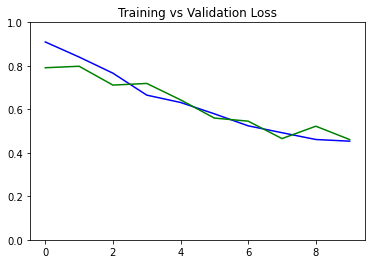

In [15]:
plot_metrics("loss", title="Training vs Validation Loss", ylim=1)

After each epoch loss is decreasing stating that we can improve our accuracy more on further training.


---



---



#Prediction

In [16]:
def get_test_image_and_annotation_array():
    ds = test_dataset.unbatch()
    ds = ds.batch(info.splits['test'].num_examples)
    images = []
    y_true_segments = []

    for image,annotation in ds.take(1):
        y_true_segments = annotation.numpy()
        images = image.numpy()
    y_true_segments = y_true_segments[:(info.splits['test'].num_examples - (info.splits['test'].num_examples % BATCH_SIZE))]
  
    return images[:(info.splits['test'].num_examples - (info.splits['test'].num_examples % BATCH_SIZE))], y_true_segments

def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask,-1)
    pred_mask = pred_mask[...,tf.newaxis]
    return pred_mask[0].numpy()

def make_prediction(image, mask, num=1):
    image = np.reshape(image,(1,image.shape[0],image.shape[1],image.shape[2]))
    pred_mask = model.predict(image)
    pred_mask = create_mask(pred_mask)
    return pred_mask

Calculation of IOU and Dice score

In [17]:
def class_wise_metrics(y_true, y_pred):
    class_wise_iou = []
    class_wise_dice_score = []
    smoothening_factor = 0.00001
    for i in range(3):
        intersection = np.sum((y_pred == 1)*(y_true == 1))
        y_true_area = np.sum((y_true == 1))
        y_pred_area = np.sum((y_pred == 1))
        combined_area = y_true_area + y_pred_area
        iou = (intersection+smoothening_factor)/(combined_area-intersection+smoothening_factor)
        dice_score = 2*iou
        class_wise_iou.append(iou)
        class_wise_dice_score.append(dice_score)

        return class_wise_iou, class_wise_dice_score

In [18]:
y_true_images, y_true_segments = get_test_image_and_annotation_array()
results = model.predict(test_dataset, steps=info.splits['test'].num_examples//BATCH_SIZE)
results = np.argmax(results, axis=3)
results = results[..., tf.newaxis]

In [19]:
cls_wise_iou, cls_wise_dice_score = class_wise_metrics(y_true_segments, results)

# show the IOU for each class
for idx, iou in enumerate(cls_wise_iou):
  spaces = ' ' * (10-len(class_names[idx]) + 2)
  print("{}{}{} ".format(class_names[idx], spaces, iou)) 

# show the Dice Score for each class
for idx, dice_score in enumerate(cls_wise_dice_score):
  spaces = ' ' * (10-len(class_names[idx]) + 2)
  print("{}{}{} ".format(class_names[idx], spaces, dice_score)) 

pet         0.5457175146394643 
pet         1.0914350292789285 


#Show Predictions

<PIL.Image.Image image mode=RGB size=128x128 at 0x7FE05406C190>
<PIL.Image.Image image mode=L size=128x128 at 0x7FE0551A4890>
<PIL.Image.Image image mode=L size=128x128 at 0x7FE054991B90>


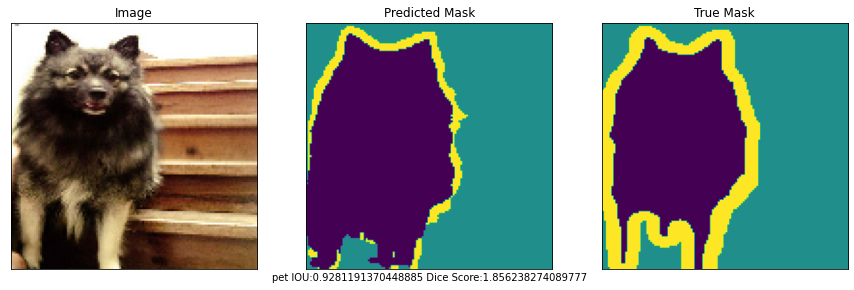

In [20]:
# Please input a number between 0 to 3647 to pick an image from the dataset
integer_slider = 3646

# Get the prediction mask
y_pred_mask = make_prediction(y_true_images[integer_slider], y_true_segments[integer_slider])

# Compute the class wise metrics
iou, dice_score = class_wise_metrics(y_true_segments[integer_slider], y_pred_mask)  

# Overlay the metrics with the images
display_iou_and_dice_score([y_true_images[integer_slider], y_pred_mask, y_true_segments[integer_slider]], iou, dice_score)

##Saving and loading weights

In [ ]:
model.save_weights('weights.h5')
# to load pretrained weights from checkpoints file
model1 = Unet()
model1.load_weight(checkpoint_path)